# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.10000000149011612


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size) 
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done", "priority", "index"])
        self.seed = random.seed(seed)
        self.index = -1
        self.priority = 1.001
    def add(self, state, action, reward, next_state, done):
        self.index = (self.index+1)%self.batch_size
        e = self.experience(state, action, reward, next_state, done, self.priority, self.index)
        self.memory.append(e)
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
    
#         dist = []
#         lst = []
#         sumPriority = np.sum([a[5] for a in self.memory])
#         for entry in self.memory:
#             lst.append(entry)
#             dist.append(entry[5]/sumPriority)
#         selected_indices = np.random.choice(len(self.memory), size = self.batch_size, p = dist).tolist()
#         experiences = np.array(lst)[selected_indices]
#         experiences_dist = np.array(dist)[selected_indices]
#         prob = torch.from_numpy(np.vstack([e for e in experiences_dist if e is not None])).float().to(device)
#         states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(device)
#         actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).float().to(device)
#         rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(device)
#         next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(device)
#         dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
#         indices = torch.from_numpy(np.vstack([e[6] for e in experiences if e is not None])).long().to(device)
#         return (states, actions, rewards, next_states, dones, prob, indices)

    def update(self, indices, priorities):
        for index, priority in zip(indices, priorities):
            for entry in self.memory:
                if index == entry[6]:
                    entry[5] = priority
                
    def __len__(self):
        return len(self.memory)
    
    
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.bn(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
import random
import copy
from collections import namedtuple, deque

BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3              
LR_ACTOR = 8.5e-5      
LR_CRITIC = 2e-4    
WEIGHT_DECAY = 0.        
# 8e-5 and 1.5e-4 had a high of 0.38 !!

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# memory = ReplayBuffer(action_size=2, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=2)
class Agent():
    
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        self.epsilon = 1.0
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.noise = OUNoise(action_size, random_seed)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
        
        self.count = 0
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.count += 1
        if len(self.memory) > BATCH_SIZE and self.count%5 == 0:
            self.count = 0
            for _ in range(1):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

#     def act(self, state, add_noise=True):
#         state = torch.from_numpy(state).float().to(device)
#         self.actor_local.eval()
#         action=np.zeros((2, 24))
#         with torch.no_grad():
# #             action = self.actor_local(state).cpu().data.numpy()
#             for i in enumerate(state):
#                 if random.random() > 0:
#                     action_to_take = self.actor_local(i[1]).cpu().data.numpy()
#                 else:
#                     action_to_take = random.choice(np.arange(self.action_size))
#                 action[i[0], :] = action_to_take
#         self.actor_local.train()
#         if add_noise:
#             action += self.epsilon * self.noise.sample()
#         return np.clip(action, -1, 1)
    def act(self, state, eps=0, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        action=np.zeros((num_agents, action_size))
        with torch.no_grad():
            for i in enumerate(state):
                if random.random() > eps:
                    action_to_take = self.actor_local(i[1]).cpu().data.numpy()
                else:
                    action_to_take = random.choice(np.arange(self.action_size))
                action[i[0], :] = action_to_take
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
#         states, actions, rewards, next_states, dones, prob, indices = experiences
        states, actions, rewards, next_states, dones = experiences
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)     
#         self.epsilon -= 1e-6
#         self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



Episode 100	Average Score: -0.0050
Episode 200	Average Score: -0.0050
Episode 300	Average Score: -0.0050
Episode 400	Average Score: -0.0050
Episode 500	Average Score: -0.0050
Episode 600	Average Score: -0.0050
Episode 700	Average Score: -0.0050
Episode 800	Average Score: -0.0050
Episode 900	Average Score: -0.0050
Episode 1000	Average Score: -0.0050
Episode 1100	Average Score: -0.0050
Episode 1200	Average Score: -0.0050
Episode 1300	Average Score: -0.0050
Episode 1400	Average Score: -0.0050
Episode 1500	Average Score: -0.0050
Episode 1600	Average Score: -0.0050
Episode 1700	Average Score: -0.0050
Episode 1800	Average Score: -0.0050
Episode 1900	Average Score: -0.0050
Episode 2000	Average Score: -0.0050
Episode 2100	Average Score: -0.0050
Episode 2200	Average Score: -0.0050
Episode 2300	Average Score: -0.0050
Episode 2400	Average Score: -0.0050
Episode 2500	Average Score: -0.0050
Episode 2600	Average Score: -0.0050
Episode 2700	Average Score: -0.0050
Episode 2800	Average Score: -0.0050
E

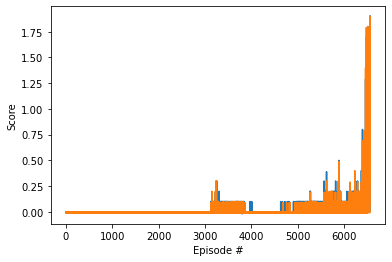

In [10]:
import matplotlib.pyplot as plt

agent = Agent(state_size=24, action_size=2, random_seed=2)
def ddpg(n_episodes=30000, max_t=700, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations   
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations   
            reward = env_info.rewards                         # get reward (for each agent)
            done = env_info.local_done
            for st, ac, re, ne, do in zip(state, action, reward, next_state, done):
                agent.step(st, ac, re, ne, do)
            state = next_state
            score += reward
            if np.any(done):
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actorA.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_criticA.pth')
#         torch.save(agentB.actor_local.state_dict(), 'checkpoint_actorB.pth')
#         torch.save(agentB.critic_local.state_dict(), 'checkpoint_criticB.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > (0.5):
            print('\nEnvironment solved in {} episodes.\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```